In [1]:
import pandas as pd
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
from scripts.OutlierRemover import OutlierRemover
from scripts.ModelTrainer import ModelTrainer
from visualization import *
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer 
from sklearn.ensemble import ExtraTreesRegressor, IsolationForest
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    roc_curve,
    auc, accuracy_score,roc_auc_score, log_loss
)
# imbalance learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

train_df = pd.read_csv('D_TaskData/cirrhosis_train.csv')
test_df = pd.read_csv('D_TaskData/crrrhosis_test.csv')


train_size = train_df.shape
test_size = test_df.shape

train_size, test_size


((224, 20), (88, 20))

In [2]:
train_df.head()

,trainID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,191,D,Placebo,24803,M,Y,Y,N,Y,1.3,151.0,3.08,73.0,1112.0,46.50,49.0,213.0,13.2,4
1,2,326,D,Placebo,18199,F,N,Y,Y,S,6.6,244.0,3.41,199.0,1819.0,170.50,91.0,132.0,12.1,3
2,3,1067,CL,Placebo,17874,F,N,Y,N,S,8.7,310.0,3.89,107.0,637.0,117.00,242.0,298.0,9.6,2
3,4,824,D,D-penicillamine,19577,F,Y,Y,Y,N,1.2,269.0,3.12,NaN,1441.0,165.85,68.0,166.0,11.1,4
4,5,186,D,Placebo,21483,F,N,Y,Y,N,3.2,260.0,3.19,91.0,815.0,127.10,101.0,160.0,12.0,4


In [3]:
rename_cols = lambda df: [
    col.lower()
    if col != 'trainID'
    else 'train_id'
    for col in df.columns
]

In [4]:
train_df.columns = rename_cols(train_df)
test_df.columns = rename_cols(test_df)

In [5]:
train_df.drop(columns=['train_id'], inplace=True)

In [6]:
uniques = train_df.nunique().sort_values(ascending=False)
uniques

age              222
n_days           220
alk_phos         213
platelets        170
cholesterol      156
sgot             148
copper           140
tryglicerides    126
albumin          115
bilirubin         75
prothrombin       40
stage              4
status             3
edema              3
spiders            2
hepatomegaly       2
ascites            2
sex                2
drug               2
dtype: int64

In [7]:
cut_off = 4
cat_cols = uniques[uniques <= cut_off].index.tolist()

for col in cat_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

pd.DataFrame(
    data = [
        [col, train_df[col].unique().tolist(), len(train_df[col].unique())]
        for col in cat_cols
    ],
    columns = ['Feature','Unique values', 'Number of unique values'],
)

,Feature,Unique values,Number of unique values
0,stage,"[4, 3, 2, 1]",4
1,status,"[D, CL, C]",3
2,edema,"[Y, S, N]",3
3,spiders,"[N, Y]",2
4,hepatomegaly,"[Y, N]",2
5,ascites,"[Y, N]",2
6,sex,"[M, F]",2
7,drug,"[Placebo, D-penicillamine]",2


`stage` should be transformed as ordinal

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   n_days         224 non-null    int64   
 1   status         224 non-null    category
 2   drug           224 non-null    category
 3   age            224 non-null    int64   
 4   sex            224 non-null    category
 5   ascites        224 non-null    category
 6   hepatomegaly   224 non-null    category
 7   spiders        224 non-null    category
 8   edema          224 non-null    category
 9   bilirubin      224 non-null    float64 
 10  cholesterol    201 non-null    float64 
 11  albumin        224 non-null    float64 
 12  copper         222 non-null    float64 
 13  alk_phos       224 non-null    float64 
 14  sgot           224 non-null    float64 
 15  tryglicerides  200 non-null    float64 
 16  platelets      221 non-null    float64 
 17  prothrombin    224 non-null    floa

In [9]:
metadata = {
    'target': 'status',
    'categorical_cols': [],
    'numerical_cols': []
}
tmp_cats = []
tmp_nums = []

for col in train_df.columns:
    if col != metadata['target'] and col in cat_cols:
        metadata['categorical_cols'].append(col)
    elif col != metadata['target']:
        metadata['numerical_cols'].append(col)
metadata

{'target': 'status',
 'categorical_cols': ['drug',
  'sex',
  'ascites',
  'hepatomegaly',
  'spiders',
  'edema',
  'stage'],
 'numerical_cols': ['n_days',
  'age',
  'bilirubin',
  'cholesterol',
  'albumin',
  'copper',
  'alk_phos',
  'sgot',
  'tryglicerides',
  'platelets',
  'prothrombin']}

In [10]:
na_df = ((train_df.isna().sum() / train_df.shape[0]) * 100).round(2)
missing_cols = na_df[na_df > 0].index.tolist()

pd.DataFrame({
    '% missing': na_df[na_df > 0],
    'n_missing': (
        train_df.isna().sum()
        [na_df[na_df > 0].index]
    )
}).sort_values(by='% missing', ascending=False)



,% missing,n_missing
tryglicerides,10.71,24
cholesterol,10.27,23
platelets,1.34,3
copper,0.89,2


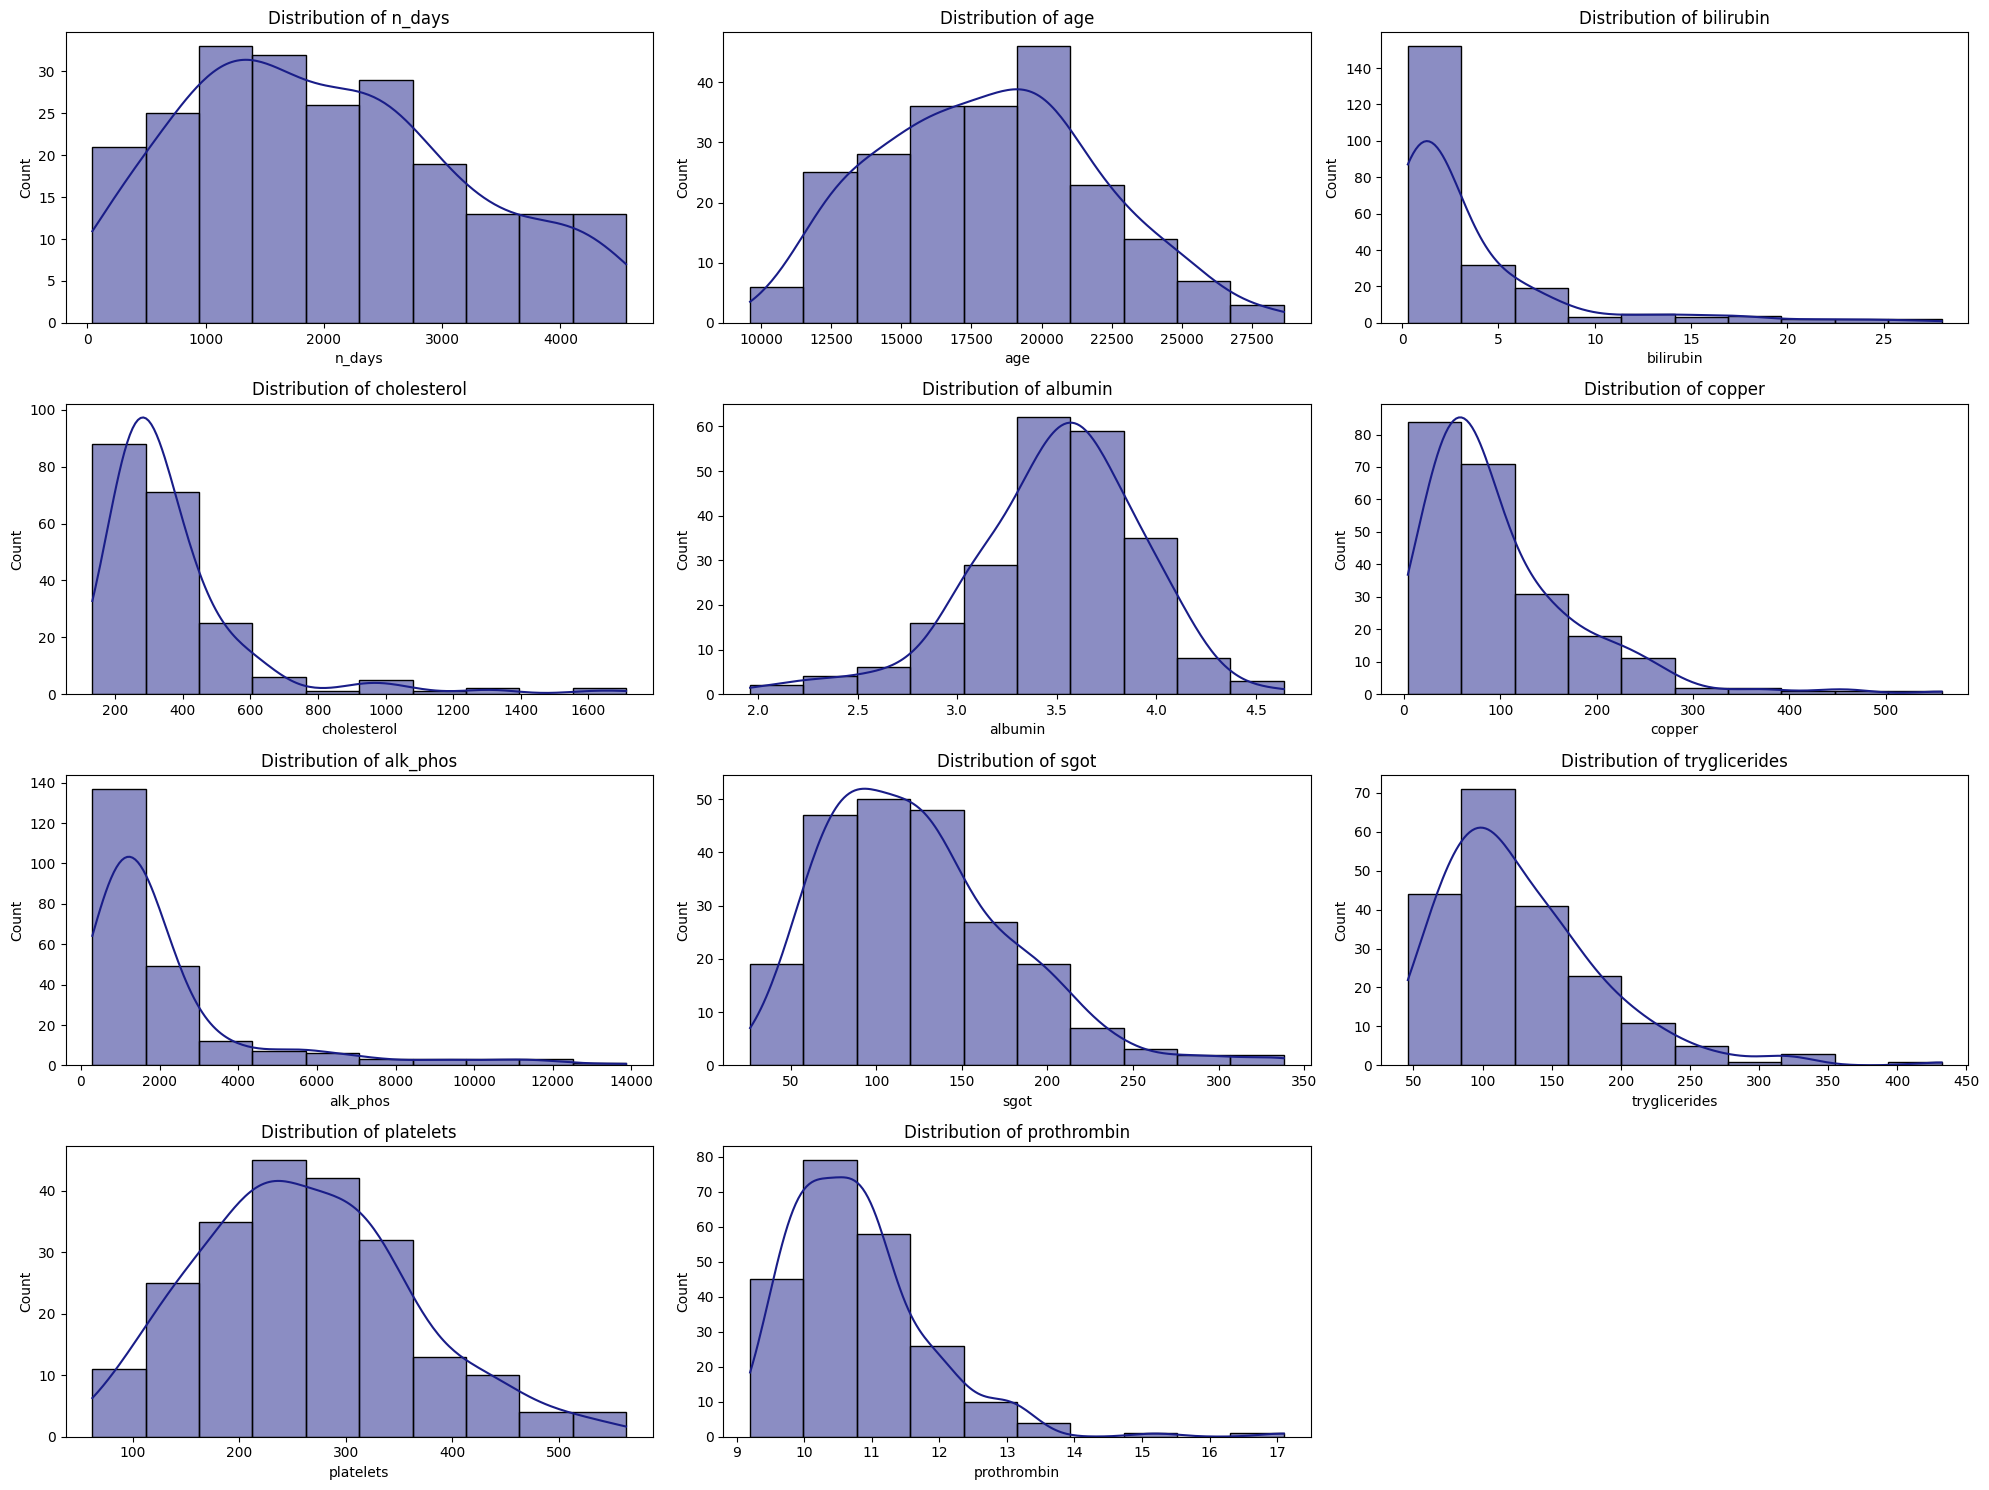

In [11]:
NumericVisualizer(train_df).plot(
    kind='dist',
    cols=metadata['numerical_cols'],
    figsize=(20,15)
)

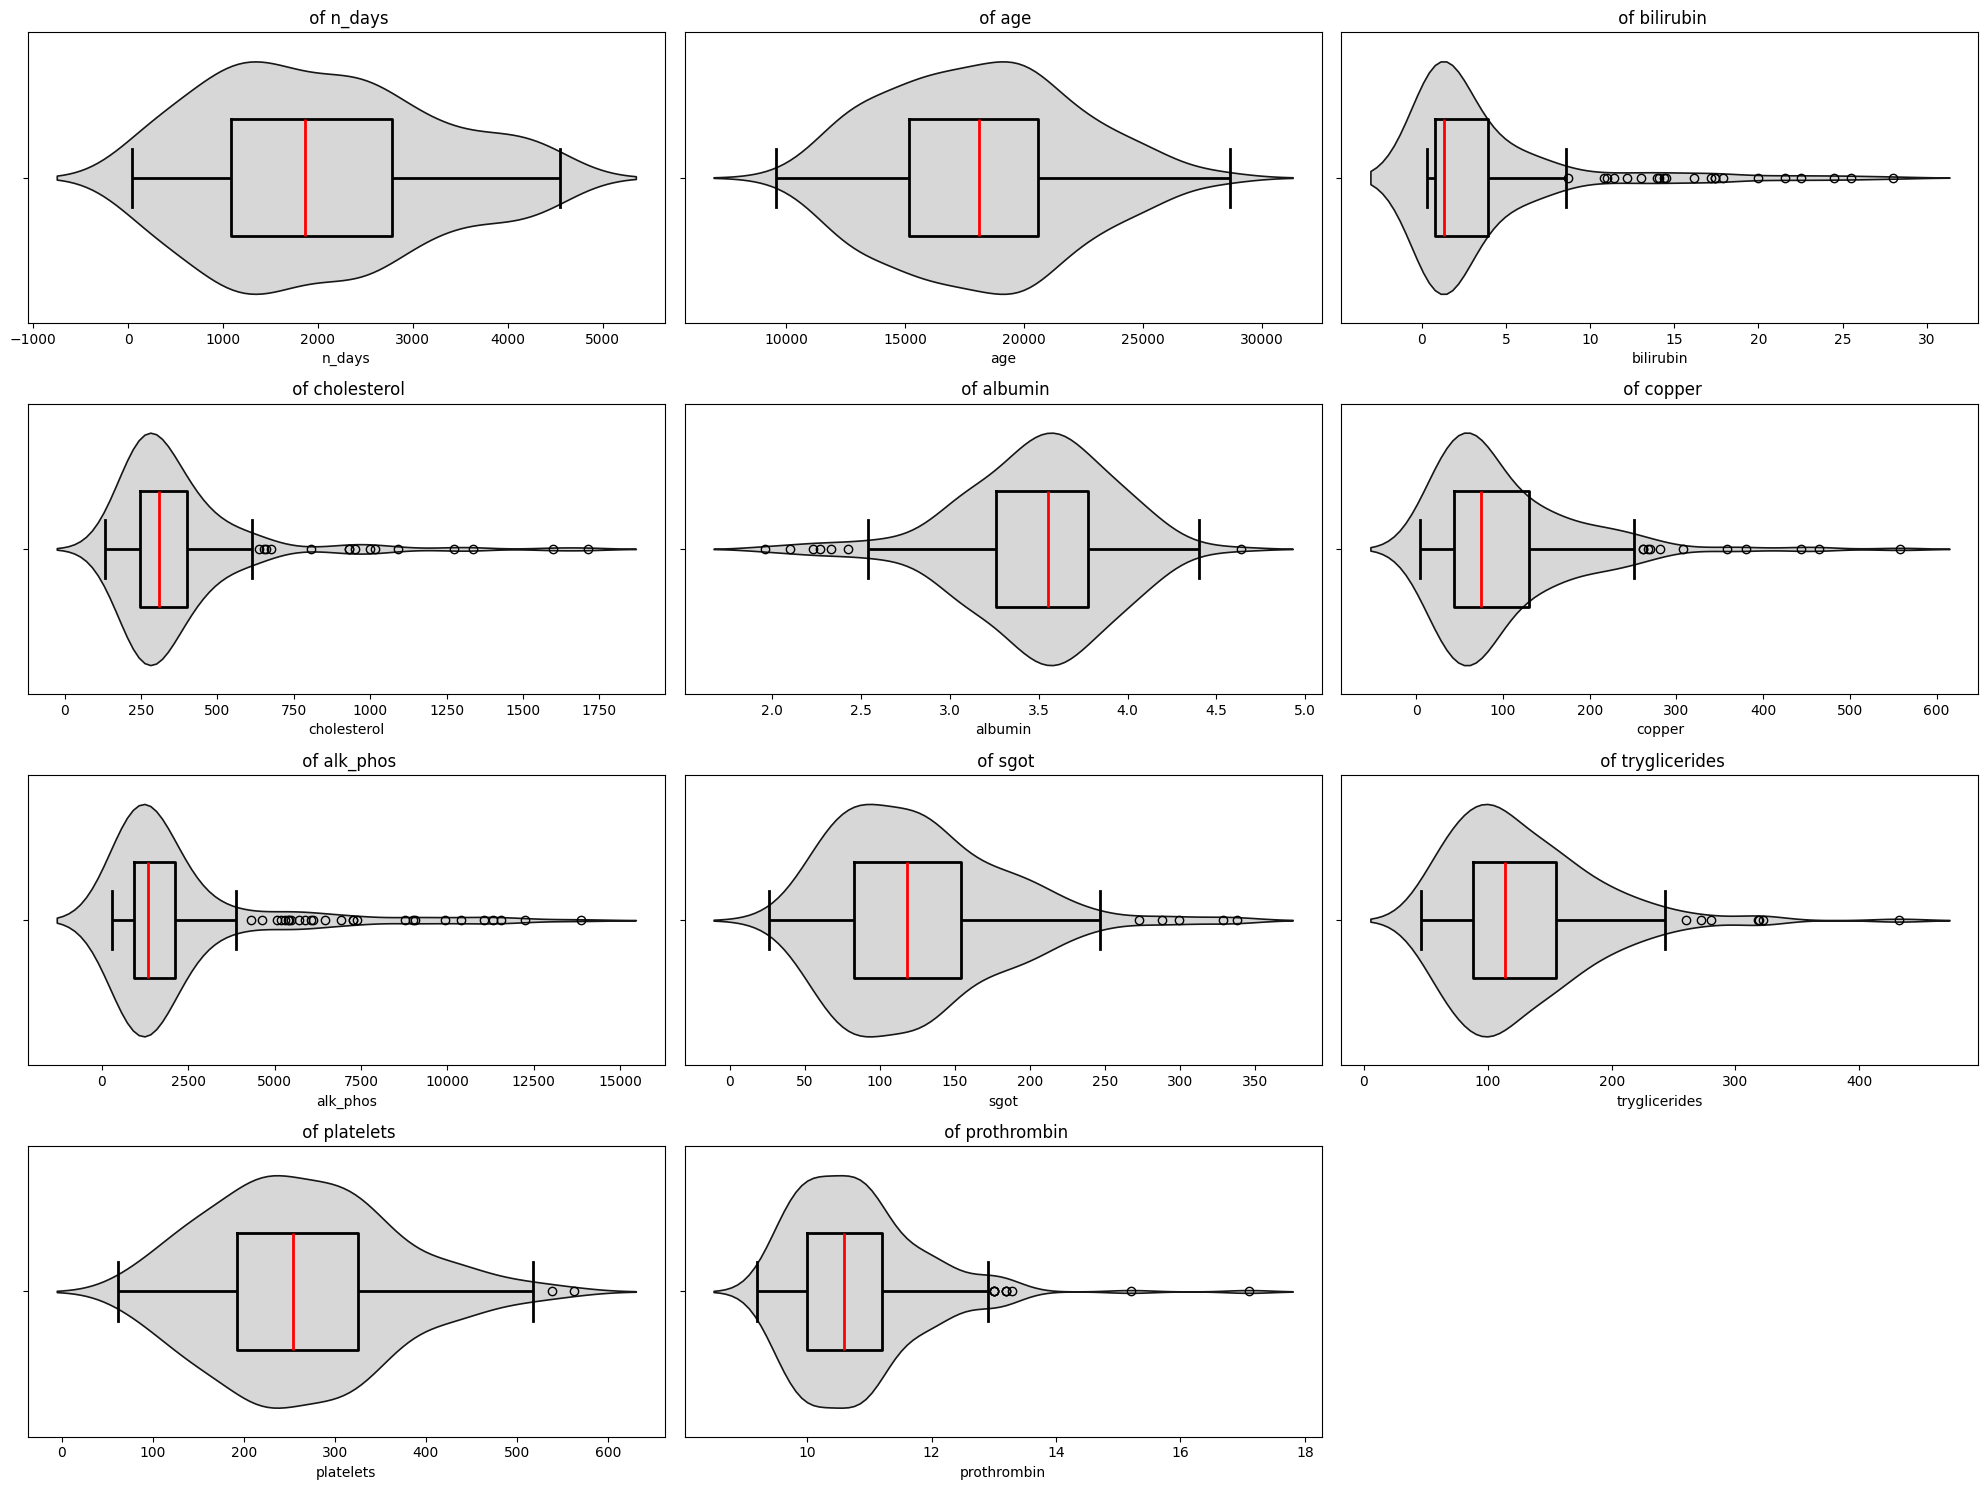

In [12]:
NumericVisualizer(train_df).plot(
    kind='box',
    cols=metadata['numerical_cols'],
    figsize=(20,15),
    vert=False,
    box_width=.4,
    box_color= 'black',
    vin_color='lightgray'
)

In [13]:
log_trs_cols = ['bilirubin',
 'cholesterol',
 'copper',
 'alk_phos',
 'sgot',
 'tryglicerides',
 'prothrombin']

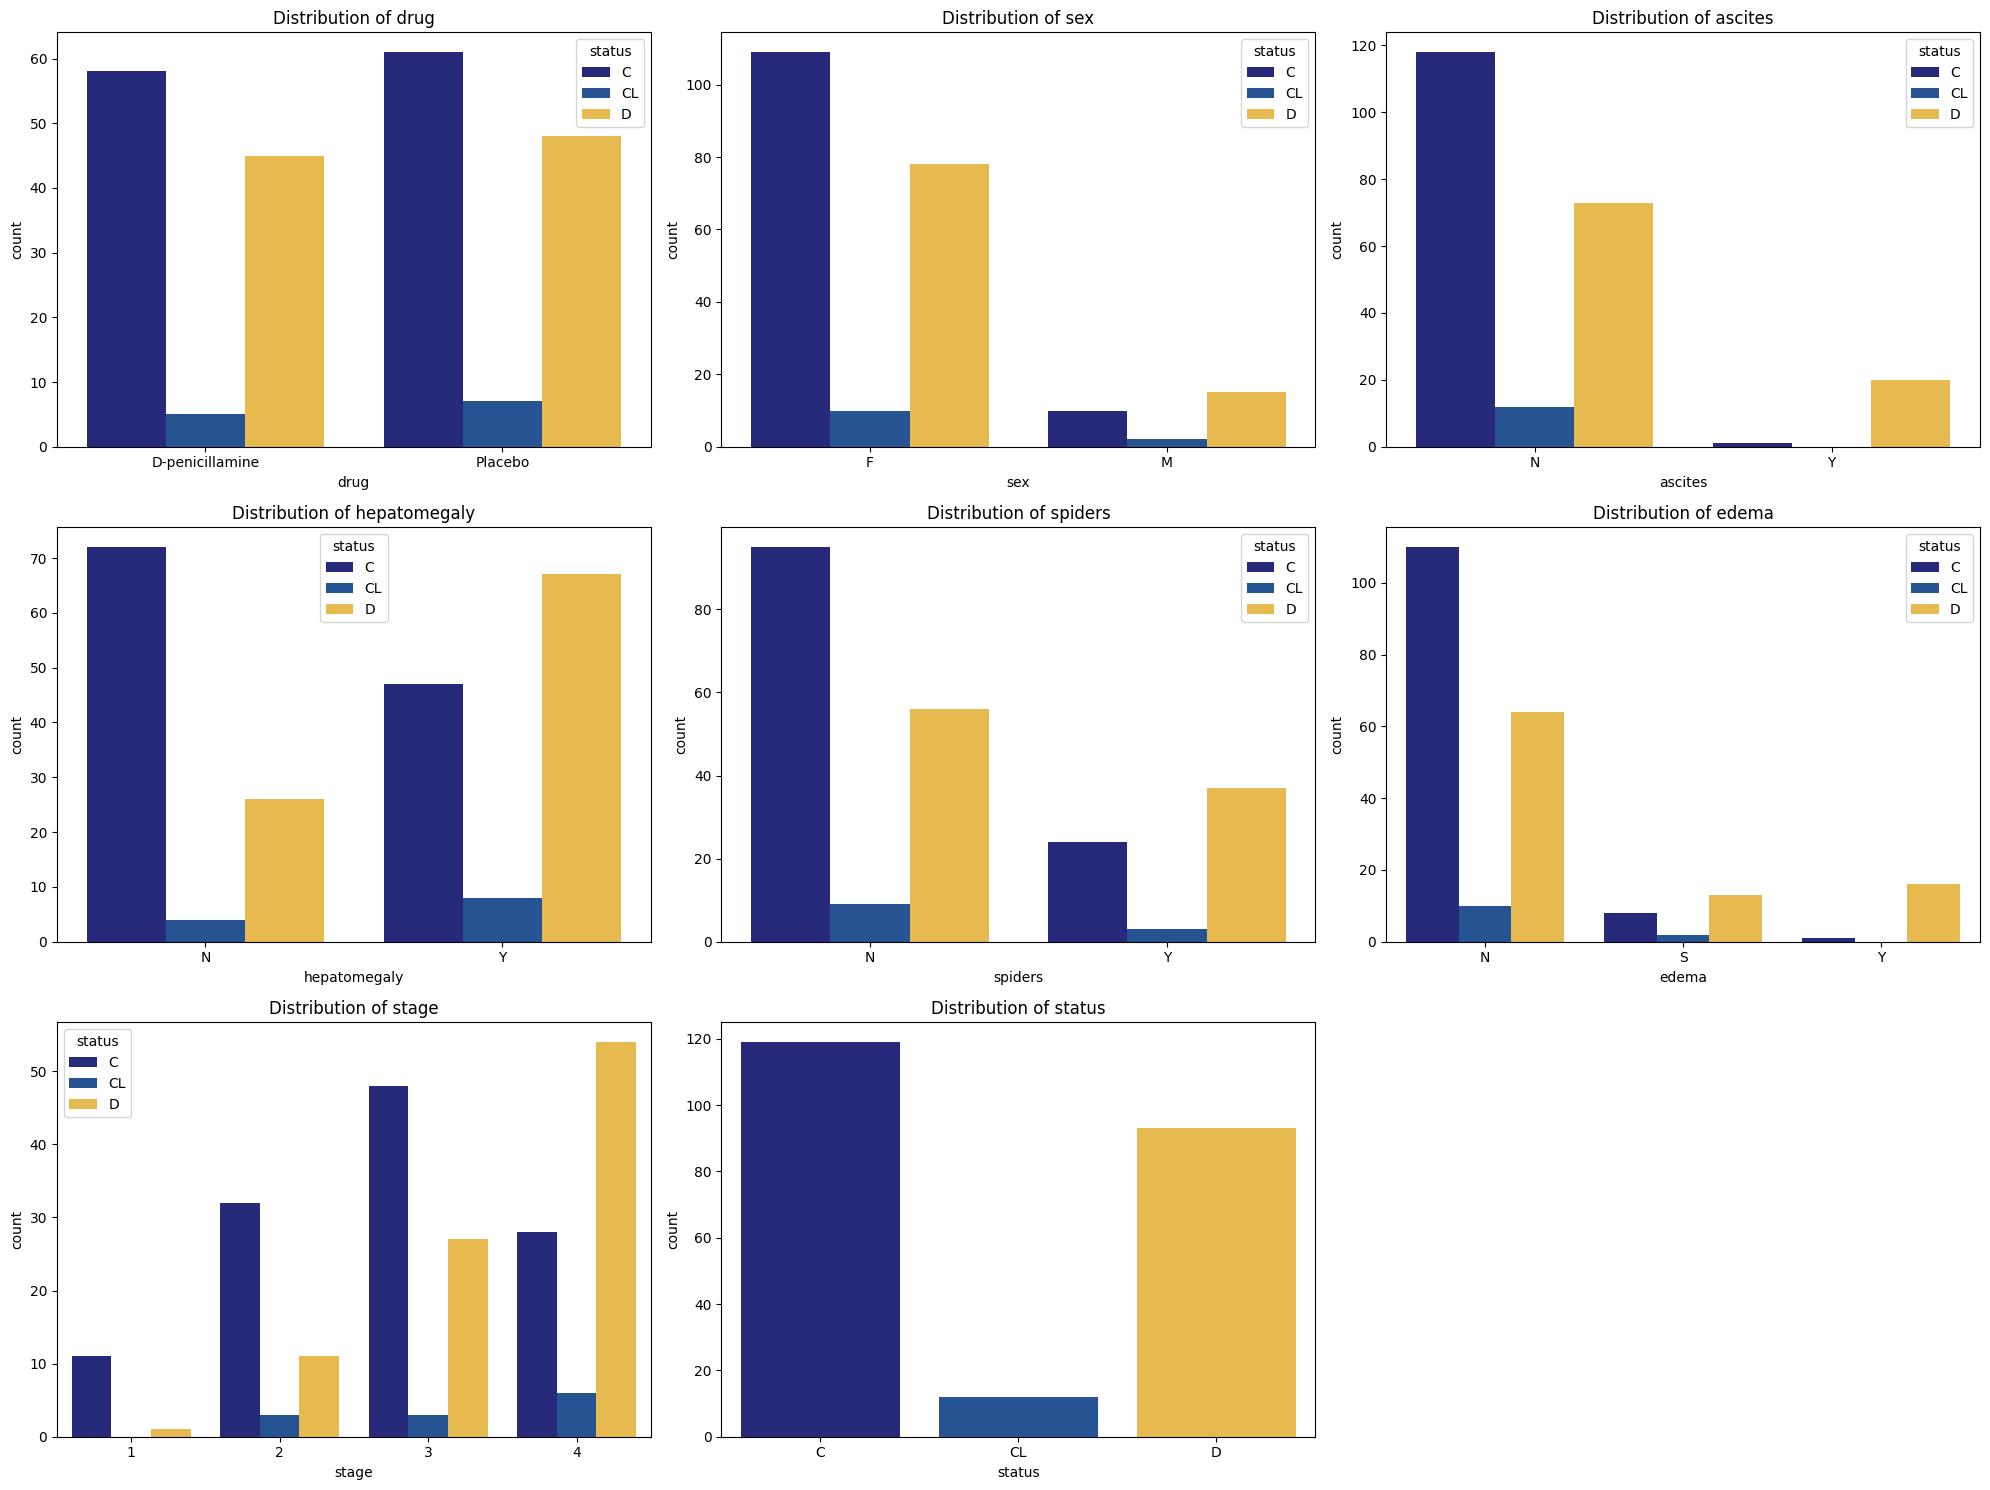

In [14]:
CategoricalVisualizer(train_df).plot(
    metadata['categorical_cols'] + [metadata['target']],
    tgt_col='status',
    figsize=(20,15)
)

# Handling Outlier

In [16]:
train_df[metadata['numerical_cols']]

,n_days,age,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin
0,191,24803,1.3,151.0,3.08,73.0,1112.0,46.50,49.0,213.0,13.2
1,326,18199,6.6,244.0,3.41,199.0,1819.0,170.50,91.0,132.0,12.1
2,1067,17874,8.7,310.0,3.89,107.0,637.0,117.00,242.0,298.0,9.6
3,824,19577,1.2,269.0,3.12,NaN,1441.0,165.85,68.0,166.0,11.1
4,186,21483,3.2,260.0,3.19,91.0,815.0,127.10,101.0,160.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
219,3823,10550,1.0,239.0,3.77,77.0,1877.0,97.65,101.0,312.0,10.2
220,1152,25546,2.3,586.0,3.01,243.0,2276.0,114.70,126.0,339.0,10.9
221,2540,23107,14.4,448.0,3.65,34.0,1218.0,60.45,318.0,385.0,11.7
222,4184,11868,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0


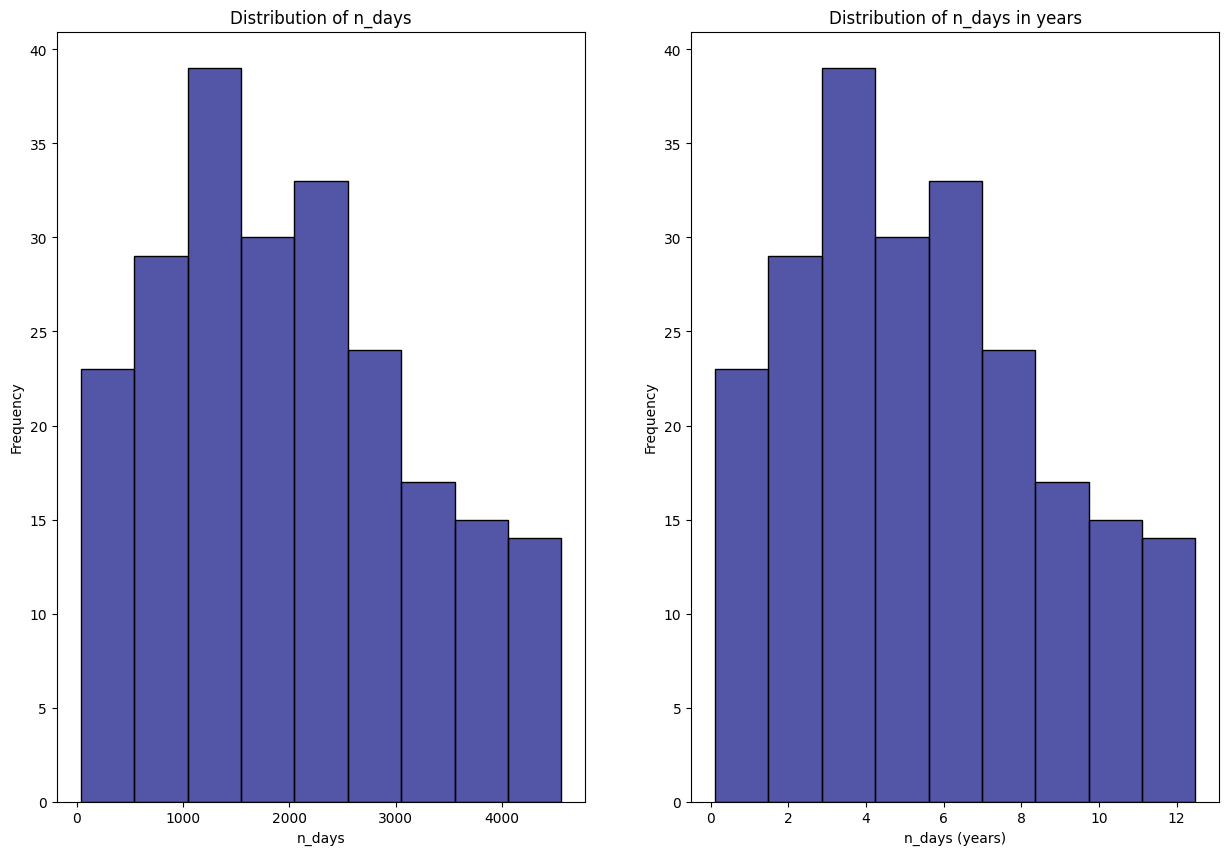

In [22]:
# fig, ax = plt.subplots(figsize=(20,15),nrows=1, ncols=2)
# sns.displot(train_df['n_days'], ax=ax[0])
# sns.displot(train_df['n_days']/365, ax=ax[1])

fig, ax = plt.subplots(figsize=(15, 10), nrows=1, ncols=2)

# Use histplot to plot histograms on the provided axes
sns.histplot(train_df['n_days'], ax=ax[0])
ax[0].set_title('Distribution of n_days')
ax[0].set_xlabel('n_days')
ax[0].set_ylabel('Frequency')

sns.histplot(train_df['n_days'] / 365, ax=ax[1])
ax[1].set_title('Distribution of n_days in years')
ax[1].set_xlabel('n_days (years)')
ax[1].set_ylabel('Frequency')

plt.show()

In [15]:
i_imputer = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=100),
    random_state=42,
    max_iter=100,
    njobs=-1
)

isf = IsolationForest(
    random_state=42, 
    n_estimators=100, 
    contamination=.05, 
    n_jobs=-1
)

hdling_outliers_pl = Pipeline(steps=[
    ('impute', i_imputer),
    ('detect_outliers', isf)
])

hdling_outliers_ct = ColumnTransformer(
    transformers=[
        ('rm_outliers', hdling_outliers_pl, metadata['numerical_cols'])
    ]
)

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [113]:
clean_df = train_df[outliers == 1]

In [115]:

isf = IsolationForest(random_state=42, n_estimators=100)
log_transformer = FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one')
preprocessor = ColumnTransformer(
    transformers=[
        (
            'log',
            Pipeline(steps=[
                ('imputer', i_imputer),
                ('transfom', log_transformer),
                ('scaler', RobustScaler())
            ]),
            log_trs_cols
        ),
        (
            'cat',
            Pipeline(steps=[
                ('imputer', KNNImputer(n_neighbors=5)),
                ('encoder', OneHotEncoder())
            ]),
            list(
                filter(
                    (lambda cat: cat != 'stage'),
                    metadata['categorical_cols']
                ))
        ),
        (
            'ord',
            Pipeline(steps=[
                ('encoder', OrdinalEncoder())
            ]),
            ['stage']
        ),
        
    ],
    remainder=Pipeline(steps=[
        ('imputer', i_imputer),
        ('scaler', RobustScaler())
    ])
)

In [116]:
X_train, X_val, y_train, y_val = train_test_split(
    clean_df.drop(columns=[metadata['target']]),
    clean_df[metadata['target']],
    test_size=.2,
    random_state=42,
    stratify=clean_df[metadata['target']]
)

In [117]:
preprocessor.fit(X_train)

ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('log',
                                 Pipeline(steps=[('transfom',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['bilirubin', 'cholesterol', 'copper',
                                  'alk_phos', 'sgot', 'tryglicerides',
                                  'prothrombin']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['drug', 'sex', 'ascites', 'hepatomegaly',
                                  'spiders', 'edema']),
                                ('ord',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder())]),
                                 ['stage'])])

In [118]:
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.fit_transform(X_val)

In [119]:
column_names = preprocessor.get_feature_names_out()

X_train_prep = pd.DataFrame(X_train_prep, columns=column_names)
X_val_prep  = pd.DataFrame(X_val_prep, columns = column_names)

In [120]:
y_train = LabelEncoder().fit_transform(y_train)
y_val = LabelEncoder().fit_transform(y_val)


In [121]:
te

,testid,n_days,status,drug,age,sex,ascites,hepatomegaly,spiders,edema,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin,stage
0,1,2583,NaN,D-penicillamine,18393,F,N,N,N,N,0.4,127.0,3.50,14,1062.0,49.60,84.0,334.0,10.3,2
1,2,1360,NaN,D-penicillamine,24020,M,N,N,N,N,1.8,416.0,3.94,121,10165.0,79.98,219.0,213.0,11.0,3
2,3,3445,NaN,Placebo,23445,M,N,Y,Y,N,0.6,252.0,3.83,41,843.0,65.10,83.0,336.0,11.4,4
3,4,1235,NaN,D-penicillamine,23241,F,N,N,Y,N,3.8,426.0,3.22,96,2716.0,210.80,113.0,228.0,10.6,2
4,5,786,NaN,Placebo,16839,F,N,Y,N,N,2.9,332.0,3.60,86,1492.0,134.85,103.0,277.0,11.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,939,NaN,D-penicillamine,22767,F,N,N,N,N,1.7,434.0,3.35,39,1713.0,171.00,100.0,234.0,10.2,2
84,85,2449,NaN,D-penicillamine,16216,F,N,N,N,N,1.5,293.0,4.30,50,975.0,125.55,56.0,336.0,9.1,2
85,86,2574,NaN,D-penicillamine,19237,F,N,N,N,N,0.5,NaN,4.52,31,784.0,74.40,NaN,361.0,10.1,3
86,87,737,NaN,D-penicillamine,14558,F,N,Y,Y,N,3.1,227.0,3.75,121,1136.0,110.00,91.0,264.0,10.0,3


In [127]:
X_test = test_df.drop(columns=[metadata['target']])
X_test.dropna(inplace=True)

In [125]:
completed_pl = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])  

completed_pl.fit(X_train, y_train)
y_train_pred = completed_pl.predict(X_train)

print(classification_report(y_train, y_train_pred))

y_test_pred = completed_pl.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        67

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



ValueError: Input X contains NaN.
FunctionTransformer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
random_state = 42
model_list = [
    BernoulliNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=random_state, max_depth=10, max_features='sqrt', n_estimators=300),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.5),
    #SVC(),
    BalancedRandomForestClassifier(max_depth=10, n_estimators=200, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state, learning_rate = 0.2, max_depth = 10, n_estimators = 200),
    CatBoostClassifier(verbose=False),
    XGBClassifier(verbose=False),
]

In [ ]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

class Trainer:
    def __init__(self, model_list) -> None:
        self.model_list = model_list

    def fit_and_evaluate(self, X_train, y_train, X_val, y_val, metrics: str, cv: int=10) -> pd.DataFrame:
        baseline_results = pd.DataFrame(columns=['model_name', f'{metrics}_train_cv', f'{metrics}_val'])
        for idx in tqdm.tqdm(range(len(self.model_list))):
            
            clf = self.model_list[idx]
            # StratifiedKFold with shuffle to ensure class distribution is equal in each fold
            kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=2024)
          
            # Using cross_val_score
            metrics_train = np.round(
                            np.mean(
                                cross_val_score(clf, X_train, y_train,
                                scoring=metrics, cv=kfold)
                            ), 3
                        )
            # Test on validation set
            clf.fit(X_train, y_train)
            y_pred_val = clf.predict_proba(X_val)
            metrics_val = self.cal_metrics(y_val, y_pred_val)
            baseline_results.loc[len(baseline_results)] = [clf.__class__.__name__, metrics_train, metrics_val]
        return baseline_results \
                    .sort_values(by=f'{metrics}_val', ascending=False) \
                    .set_index('model_name')
    
    def cal_metrics(self, y, y_pred_proba) -> float:
        # Calculate ROC AUC score for multi-class classification
        return roc_auc_score(y_val, y_pred_proba, multi_class='ovr')

In [ ]:
base_trainer = Trainer(model_list)
baseline_results = base_trainer.fit_and_evaluate(X_res, y_res, X_val_prep, y_val, 'roc_auc')
print(baseline_results.to_markdown())

  0%|          | 0/9 [00:00<?, ?it/s]/Users/aaronnguyen/Documents/SIT307_MachineLearning/cirrhosis-survival-prediction/.ssc-venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/aaronnguyen/Documents/SIT307_MachineLearning/cirrhosis-survival-prediction/.ssc-venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/aaronnguyen/Documents/SIT307_MachineLearning/cirrhosis-survival-prediction/.ssc-venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aaronnguyen/Documents/SIT307_MachineLearning/cirrhosis-survival-pr

| model_name                     |   roc_auc_train_cv |   roc_auc_val |
|:-------------------------------|-------------------:|--------------:|
| BernoulliNB                    |                nan |      0.810433 |
| LogisticRegression             |                nan |      0.805961 |
| BalancedRandomForestClassifier |                nan |      0.795546 |
| RandomForestClassifier         |                nan |      0.772485 |
| CatBoostClassifier             |                nan |      0.748723 |
| GradientBoostingClassifier     |                nan |      0.689999 |
| AdaBoostClassifier             |                nan |      0.6269   |
| XGBClassifier                  |                nan |      0.619296 |
| DecisionTreeClassifier         |                nan |      0.610171 |


In [ ]:
trsf_num_cols = [
    s for s in preprocessor.get_feature_names_out()
    if any(
        col in s
        for col in metadata['numerical_cols']
    )
]

In [ ]:
X_pre = preprocessor.transform(clean_df.drop(columns=[metadata['target']]))
prep_df = pd.DataFrame(
    data = X_pre,
    columns = preprocessor.get_feature_names_out()
)
prep_df

,log__bilirubin,log__cholesterol,log__copper,log__alk_phos,log__sgot,log__tryglicerides,log__prothrombin,cat__drug_D-penicillamine,cat__drug_Placebo,cat__sex_F,...,cat__spiders_N,cat__spiders_Y,cat__edema_N,cat__edema_S,cat__edema_Y,ord__stage,remainder__n_days,remainder__age,remainder__albumin,remainder__platelets
0,0.066920,-2.217421,0.083192,0.000000,-1.976796,-1.336779,2.323520,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,3.0,-0.732166,1.709252,-0.834783,-0.403509
1,1.425257,-0.782573,1.055937,0.585533,0.732392,-0.250996,1.401884,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,2.0,-0.661615,0.245762,-0.260870,-1.114035
2,1.656219,-0.066764,0.454085,-0.662893,-0.052791,1.464535,-1.049584,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,-0.274366,0.173740,0.573913,0.342105
3,0.000000,-0.490923,0.661789,0.308369,0.674735,-0.762022,0.488203,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,3.0,-0.401359,0.551136,-0.765217,-0.815789
4,0.820024,-0.592671,0.296977,-0.369704,0.119859,-0.068124,1.313982,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,3.0,-0.734779,0.973518,-0.643478,-0.868421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,-0.731937,-1.133208,0.014370,-1.068470,-1.655370,-0.762022,0.488203,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.664228,0.227812,0.504348,0.096491
208,-0.152430,-0.844479,0.134937,0.622879,-0.429752,-0.068124,-0.407440,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.165926,-1.449307,0.365217,0.464912
209,0.543925,1.837086,1.249697,0.852207,-0.094189,0.319789,0.295614,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,2.0,-0.229945,1.873906,-0.956522,0.701754
210,-0.731937,0.028163,-0.264677,0.132505,0.042143,-0.476967,-0.617192,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,2.0,1.354586,-1.157230,-0.034783,-0.298246


In [ ]:
roc_auc = roc_auc_score(y_val, y_val_pred, multi_class='ovr')


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
import numbers
from warnings import warn
from copy import deepcopy

import numpy as np
from numpy import float32 as DTYPE
from numpy import float64 as DOUBLE
from scipy.sparse import issparse

from joblib import Parallel, delayed

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble._base import _set_random_states
from sklearn.ensemble._forest import _get_n_samples_bootstrap
from sklearn.ensemble._forest import _parallel_build_trees
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.exceptions import DataConversionWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import _safe_indexing
# from sklearn.utils.fixes import _joblib_parallel_args
from sklearn.utils.validation import _check_sample_weight

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.base import BaseSampler

from imblearn.utils import Substitution
from imblearn.utils._docstring import _n_jobs_docstring
from imblearn.utils._docstring import _random_state_docstring
from imblearn.utils._validation import check_sampling_strategy
from imblearn.utils._validation import _deprecate_positional_args

#from smote_nc import SMOTENC
#from smote_rus import SMOTERUS

MAX_INT = np.iinfo(np.int32).max

In [ ]:
"""Hybrid sampling using SMOTE, RUS and NC"""

from sklearn.base import clone
from sklearn.utils import check_X_y

from imblearn.base import BaseSampler
#from imblearn.base import BaseCleaningSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import RandomUnderSampler

from imblearn.utils import check_target_type
from imblearn.utils import Substitution
from imblearn.utils._docstring import _n_jobs_docstring
from imblearn.utils._docstring import _random_state_docstring
from imblearn.utils._validation import _deprecate_positional_args


@Substitution(
    sampling_strategy=BaseOverSampler._sampling_strategy_docstring,
    n_jobs=_n_jobs_docstring,
    random_state=_random_state_docstring,
)
class SMOTENCRUS(BaseSampler):
    
    """Over-sampling using SMOTE, undersampling using RUS and cleaning using ENN.
    Combine over- and under-sampling using SMOTE, RUS, and Edited Nearest Neighbours.
    
    Parameters
    ----------
    {sampling_strategy}
    {random_state}
    
    smote : sampler object, default=None
        The :class:`~imblearn.over_sampling.SMOTE` object to use. If not given,
        a :class:`~imblearn.over_sampling.SMOTE` object with default parameters
        will be given.
    Attributes
    ----------
    sampling_strategy_ : dict
        Dictionary containing the information to sample the dataset. The keys
        corresponds to the class labels from which to sample and the values
        are the number of samples to sample.
    smote_ : sampler object
        The validated :class:`~imblearn.over_sampling.SMOTE` instance.
    nc_ : sampler object
        The validated :class:`~imblearn.under_sampling.NeighbourhoodCleaningRule`
        instance.
    rus_ : sampler object
        The validated :class:`~imblearn.under_sampling.RandomUnderSampler`
        instance.
    n_features_in_ : int
        Number of features in the input dataset.
        
    """

    _sampling_type = "over-sampling"

    @_deprecate_positional_args
    def __init__(
        self,
        *,
        sampling_strategy="auto",
        random_state=None,
        smote=None,
        rus= None,
        nc= None,
        n_jobs=-1,
    ):
        super().__init__()
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.smote = smote
        self.rus= rus
        self.nc= nc
        self.n_jobs = n_jobs

    def _validate_estimator(self):
        
        if self.smote is not None:
            if isinstance(self.smote, SMOTE):
                self.smote_ = clone(self.smote)
            else:
                raise ValueError(
                    f"smote needs to be a SMOTE object."
                    f"Got {type(self.smote)} instead."
                )
        # Otherwise create a default SMOTE
        else:
            self.smote_ = SMOTE(
                sampling_strategy=self.sampling_strategy,
                random_state=self.random_state,
                n_jobs=self.n_jobs,
            )

            
        if self.rus is not None:
            if isinstance(self.rus, RandomUnderSampler):
                self.rus_ = clone(self.rus)
            else:
                raise ValueError(
                    f"enn needs to be an RUS."
                    f" Got {type(self.rus)} instead."
                )
        # Otherwise create a default RUS
        else:
            self.rus_ = RandomUnderSampler(
                sampling_strategy="auto"
            )
            
            
        if self.nc is not None:
            if isinstance(self.nc, NeighbourhoodCleaningRule):
                self.nc_ = clone(self.nc)
            else:
                raise ValueError(
                    f"enn needs to be an NeighbourhoodCleaningRule."
                    f" Got {type(self.rus)} instead."
                )
        # Otherwise create a default NC
        else:
            self.nc_ = NeighbourhoodCleaningRule(
                sampling_strategy="auto", n_jobs=self.n_jobs
            )
        

    def _fit_resample(self, X, y):
        self._validate_estimator()
        y = check_target_type(y)
        X, y = check_X_y(X, y, accept_sparse=["csr", "csc"])
        self.sampling_strategy_ = self.sampling_strategy

        X_res, y_res = self.nc_.fit_resample(X, y)
        X_res, y_res = self.rus_.fit_resample(X_res, y_res)
                                              
        return self.smote_.fit_resample(X_res, y_res)

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = BalancedRandomForestClassifier(max_depth=3)
